# Example 2: SAF Comparison

### Generating input.yaml and input.nc files

In [1]:
#%pip install pycontrails
#%pip install panadas

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
z = np.linspace(0, 20, 41)  # altitude (km)
t = np.linspace(0, 4, 49)  # elapsed time (hours)

zz, tt = np.meshgrid(z, t, indexing="ij")

p = np.where(
    z < 11.0,
    101325*(1 - 6.5*z/288.15)**(9.80/(6.5e-3*287)),
    22632*np.exp(-9.80*(z - 11)*1e3/(287*216.65))
)
T = np.where(zz < 11.0, 288.15 - 6.5*zz, 216.65)
rhi = np.where((tt <= 0.5) & (zz > 9) & (zz < 11), 1.2, 0.2)
shear = np.full_like(zz, 0.01)
w = np.full_like(zz, 0.0)

ds = xr.Dataset(data_vars = {
    "pressure": (("altitude",), p/100, {"units": "hPa"}),
    "temperature": (("altitude", "time"), T, {"units": "K"}),
    "relative_humidity_ice": (("altitude", "time"), rhi*100, {"units": "percent"}),
    "shear": (("altitude", "time"), shear, {"units": "1/s"}),
    "w": (("altitude", "time"), w, {"units": "m/s"})
}, coords = {
    "altitude": ("altitude", z, {"units": "km"}),
    "time": ("time", t, {"units": "hours"})
})  

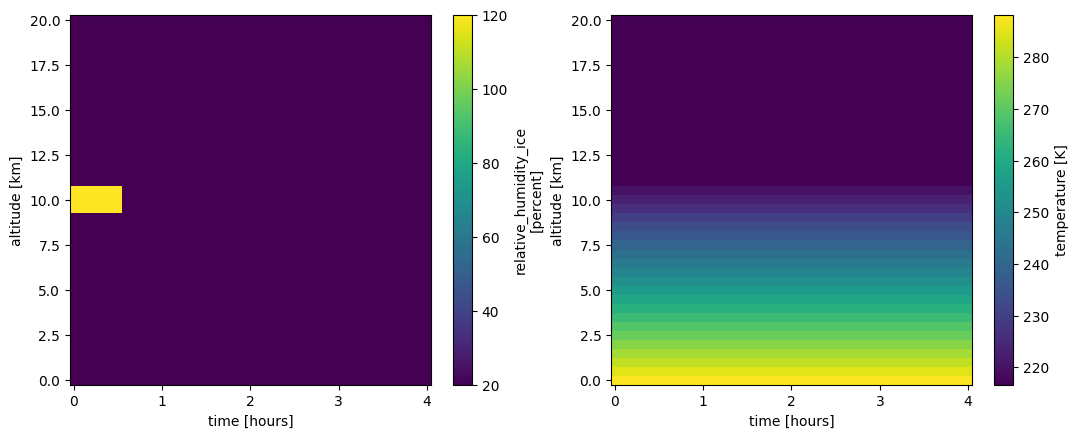

In [3]:
plt.figure(figsize=(12.8, 4.8))
plt.subplot(121)
ds["relative_humidity_ice"].plot()
plt.subplot(122)
ds["temperature"].plot()

In [4]:
from pycontrails.models.apcemm import utils
from pycontrails.models.apcemm.inputs import APCEMMInput
from pycontrails.physics import thermo

In [5]:
iz = 20  # form contrail at 10 km
theta = T[:,0]*(p[0]/p)**(287/1000)
params = APCEMMInput(
    # required parameters
    longitude=0,
    latitude=45,
    day_of_year=1,
    hour_of_day=12,
    air_pressure=p[iz],
    air_temperature=T[iz,0],
    rhw=rhi[iz,0]*thermo.e_sat_ice(T[iz,0])/thermo.e_sat_liquid(T[iz,0]),
    normal_shear=shear[iz,0],
    brunt_vaisala_frequency=np.sqrt((theta[iz+1] - theta[iz-1])/(z[iz+1] - z[iz-1])/theta[iz]),
    nox_ei=10e-3,
    co_ei=1e-3,
    hc_ei=0.6e-3,
    so2_ei=1.2e-3,
    nvpm_ei_m=0.008e-3,
    soot_radius=20e-9,
    fuel_flow=0.7,
    aircraft_mass=1e5,
    true_airspeed=260.0,
    n_engine=2,
    wingspan=35,
    core_exit_temp=550,
    core_exit_area=1,
    # optional parameters
    max_age=np.timedelta64(4, "h"),  # stop after no more than 4 hours
    dt_input_met=np.timedelta64(5, "m"),  # must match time step of met input file
    dt_apcemm_nc_output=np.timedelta64(10, "m"),  # frequency of netcdf output files
)

### Processing of data

In [6]:
import xarray as xr
import pandas as pd

In [7]:
with open("input.yaml", "w") as f:
    yaml = utils.generate_apcemm_input_yaml(params)
    f.write(yaml)

ds.to_netcdf("input.nc")

In [8]:
df = pd.read_csv("APCEMM_out/Micro000000.out", skiprows=[1]).rename(columns=lambda x: x.strip())

### Plots

#### RH against  time

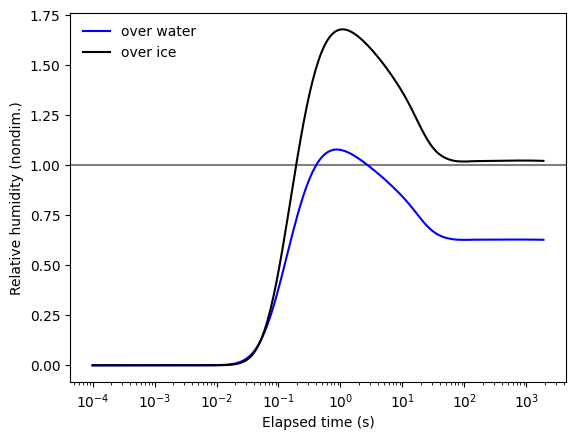

In [9]:
plt.plot(df["Time [s]"], df["RH_w [-]"], "b-", label="over water")
plt.plot(df["Time [s]"], df["RH_i [-]"], "k-", label="over ice")
plt.xlabel("Elapsed time (s)")
plt.ylabel("Relative humidity (nondim.)")
plt.gca().set_xscale("log")
plt.gca().axhline(y=1, color="gray", zorder=-1)
plt.legend(loc="upper left", frameon=False)


The plot shows a spike in relative humidity. The plume undergoes rapid cooling in the jet phase and fresh ambient air is entrained into the warm plume. As the temperature decreases, the plume reaches saturation and remains saturated for around 2 seconds. Fresh dru air enters the plume, and the relative humidity falls. When this falls below saturation, the particles start to sublimate. The loss of ice mass servers to maintain the plume's relative humidity at 100% with respect to ice. This continuies until all ice mass has melted, after which point mixing drives the plume relative humidity to the background humidity.

#### Ice Water Content Plots (not to scale)

FileNotFoundError: [Errno 2] No such file or directory: '/home/APCEMM/examples/issl_rhi140/APCEMM_out/ts_aerosol_case0_0200.nc'

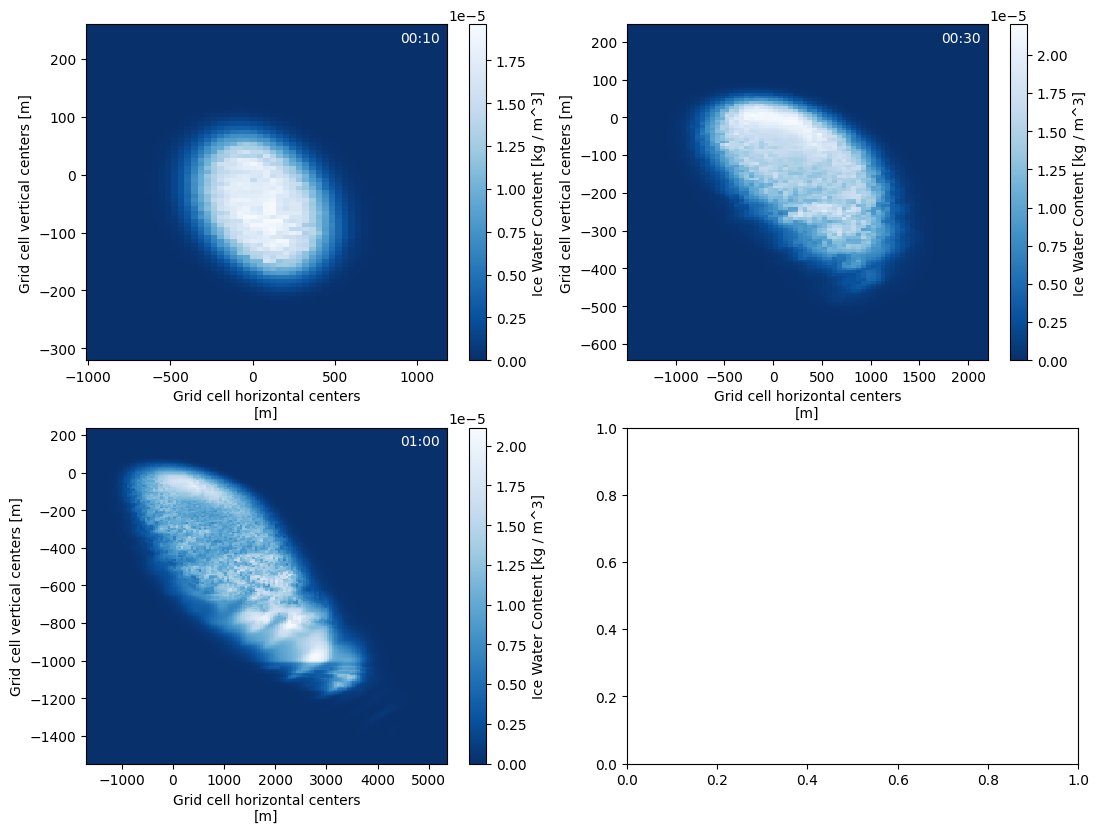

In [10]:
plt.figure(figsize=(12.8, 9.6))
plt.subplot(221)
ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0010.nc", decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate("00:10", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

plt.subplot(222)
ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0030.nc", decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate("00:30", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

plt.subplot(223)
ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0100.nc", decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate("01:00", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

plt.subplot(224)
ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0200.nc", decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate("02:00", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")
ax = plt.gca()
ax.set_xlim([-5000,12500])
ax.set_ylim([-500,200])

The plots show how the shape of the plume changes over time. Note the different color scales and axis scaling.

#### Ice Water Content Plots (to scale)

(-5000.0, 12500.0)

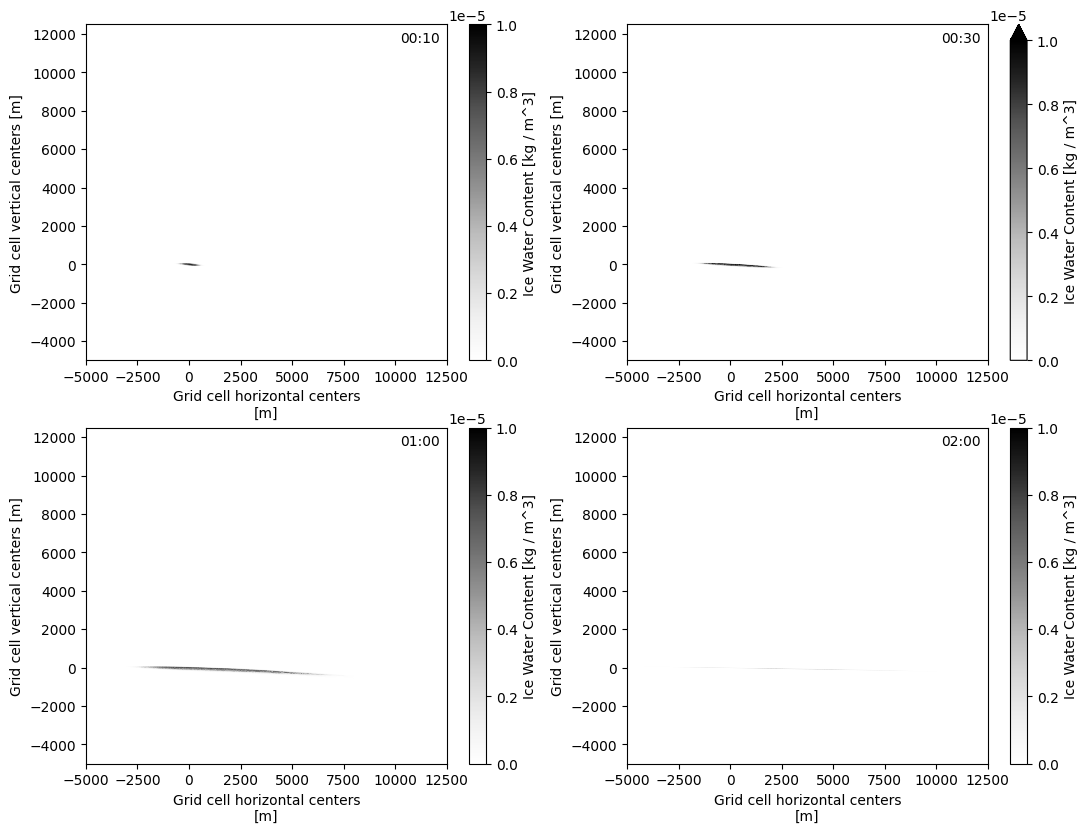

In [ ]:
plt.figure(figsize=(12.8, 9.6))
plt.subplot(221)
ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0010.nc", decode_cf=False)
ds["IWC"].plot(cmap="Greys", vmin=0, vmax=1e-5)
plt.annotate("00:10", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="black")
ax = plt.gca()
ax.set_xlim([-5000,12500])
ax.set_ylim([-5000,12500])

plt.subplot(222)
ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0030.nc", decode_cf=False)
ds["IWC"].plot(cmap="Greys", vmin=0, vmax=1e-5)
plt.annotate("00:30", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="black")
ax = plt.gca()
ax.set_xlim([-5000,12500])
ax.set_ylim([-5000,12500])

plt.subplot(223)
ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0100.nc", decode_cf=False)
ds["IWC"].plot(cmap="Greys", vmin=0, vmax=1e-5)
plt.annotate("01:00", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="black")
ax = plt.gca()
ax.set_xlim([-5000,12500])
ax.set_ylim([-5000,12500])

plt.subplot(224)
ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0200.nc", decode_cf=False)
ds["IWC"].plot(cmap="Greys", vmin=0, vmax=1e-5)
plt.annotate("02:00", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="black")
ax = plt.gca()
ax = plt.gca()
ax.set_xlim([-5000,12500])
ax.set_ylim([-5000,12500])

These plots show how the contrail shape evolves over time. Note that x,y = 0 is not fixed - the coordinate system is relative to the movement (e.g. sinking, rising) of the plume. Remember that APCEMM only simulates one plume at a time, so a real flight might have multiple plume segments connected together to form a longer contrail.

#### Evolution of Ice Crystal Size Distribution

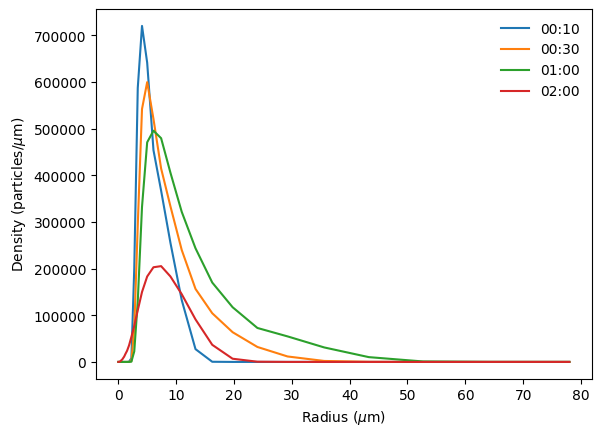

In [ ]:
plt.figure()

ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0010.nc", decode_cf=False)
plt.plot(ds["r"]*1e6, ds["Overall size distribution"]/1e6, label="00:10")

ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0030.nc", decode_cf=False)
plt.plot(ds["r"]*1e6, ds["Overall size distribution"]/1e6, label="00:30")

ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0100.nc", decode_cf=False)
plt.plot(ds["r"]*1e6, ds["Overall size distribution"]/1e6, label="01:00")

ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0200.nc", decode_cf=False)
plt.plot(ds["r"]*1e6, ds["Overall size distribution"]/1e6, label="02:00")

plt.xlabel(r"Radius ($\mu$m)")
plt.ylabel(r"Density (particles/$\mu$m)")
plt.legend(loc="upper right", frameon=False)

#### Evolution of Vertically-integrated optical depth

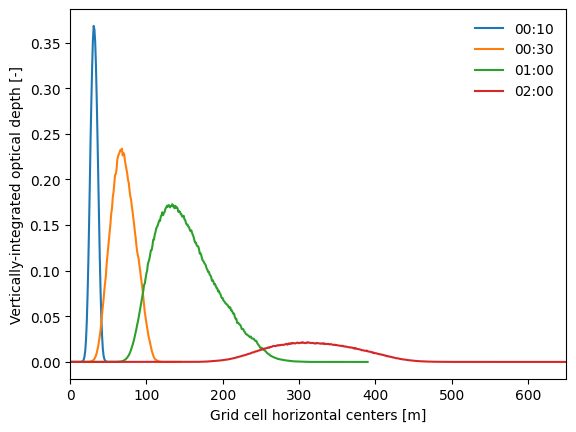

In [ ]:
plt.figure()

ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0010.nc", decode_cf=False)
plt.plot(ds["Vertical optical depth"], label="00:10")

ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0030.nc", decode_cf=False)
plt.plot(ds["Vertical optical depth"], label="00:30")

ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0100.nc", decode_cf=False)
plt.plot(ds["Vertical optical depth"], label="01:00")

ds = xr.open_dataset("APCEMM_out/ts_aerosol_case0_0200.nc", decode_cf=False)
plt.plot(ds["Vertical optical depth"], label="02:00")

ax = plt.gca()
ax.set_xlim([0,650])

plt.xlabel(r"Grid cell horizontal centers [m]")
plt.ylabel(r"Vertically-integrated optical depth [-]")
plt.legend(loc="upper right", frameon=False)


#### Evolution of Total Ice Crystal Number and Total Ice Mass

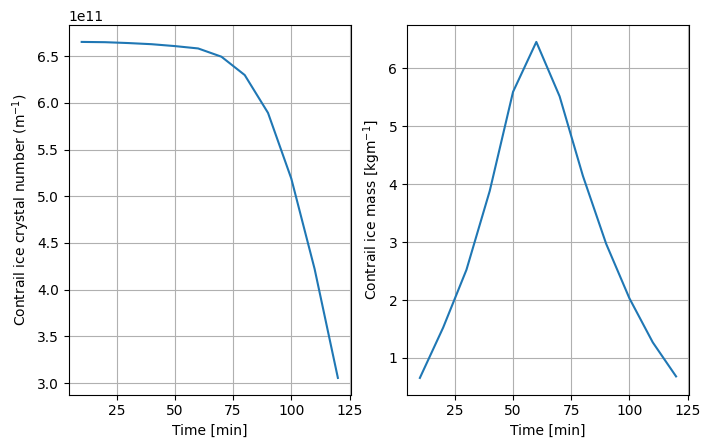

In [ ]:
time_strings = ["0010","0020","0030","0040","0050","0100","0110","0120","0130","0140","0150","0200"]
times = np.array([10,20,30,40,50,60,70,80,90,100,110,120])
masses = np.array([])
nums = np.array([])


for time in time_strings:
    path = "".join(("APCEMM_out/ts_aerosol_case0_", time, ".nc"))
    ds = xr.open_dataset(path, decode_cf=False)
    masses = np.append(masses,ds['Ice Mass'])
    nums = np.append(nums,ds['Number Ice Particles'])

plt.figure(figsize=(8, 4.8))

plt.subplot(121)
plt.plot(times, nums)
plt.ylabel("Contrail ice crystal number (m$^{-1}$)")
plt.xlabel("Time [min]")
plt.grid()

plt.subplot(122)
plt.plot(times, masses)
plt.ylabel("Contrail ice mass [kgm$^{-1}$]")
plt.xlabel("Time [min]")
plt.grid()